In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd 
from utils import train_test_validation_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, LSTM, GRU, Bidirectional
from keras.losses import sparse_categorical_crossentropy, categorical_hinge
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

## Import dataset

In [2]:
# Import data
X = pd.read_csv('../../DATA/clean_data/smart_soft_cleaning_with_nltk_stemming.csv', sep=";", index_col=0)
y = pd.read_csv('../../DATA/output_train.csv', sep=";", index_col=0)

features = X.columns
targets = y['intention'].unique()

In [3]:
X['question'].head()

0    bonjour etre tromp forum pour question alor re...
1                 etre que medic soulag contr le malad
2    medecin medic prescr medic au ordinal cachet m...
3      est-ce qu exist form adapt aux enfant age medic
4    medecin soign pour medic pharyngit et medic pr...
Name: question, dtype: object

## Prepare data for nn and find correct parameters

In [4]:
# Estimation of the size of the vocabulary 
vectorizer = CountVectorizer()
vectorizer.fit_transform(X['question'])
MAX_NB_WORDS = len(vectorizer.vocabulary_)

In [5]:
# Find max size of the sequences 
MAX_SEQUENCE_LENGTH = 0 
for sentence in X['question']:
    if MAX_SEQUENCE_LENGTH<len(sentence.split()):
        MAX_SEQUENCE_LENGTH = len(sentence.split())
MAX_SEQUENCE_LENGTH

521

In [6]:
# Preprocess text fo feed the net 
texts = X['question']
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 4974 unique tokens.


In [72]:
word_index

{'embet': 1956,
 'de': 412,
 'pop': 4353,
 'soin': 1597,
 'anxio': 2366,
 'propfan': 2513,
 'racemos': 1560,
 'color': 4716,
 'ecris': 1852,
 'circonst': 4797,
 'rajout': 1045,
 'cass': 1935,
 'experiment': 4557,
 'contiennent': 2023,
 'tujeo': 3826,
 'allong': 3828,
 'osteoporos': 3050,
 'partent': 1443,
 'devien': 2524,
 'lutein': 3343,
 'vagal': 3484,
 'medical': 1235,
 'rectum': 4382,
 'necessair': 785,
 'fibros': 4309,
 'rendent': 3907,
 'peux': 109,
 'quitt': 4441,
 'w': 3987,
 'kethoderm': 3120,
 'orgametril': 3634,
 'apport': 1223,
 'serin': 4924,
 'annulent': 1938,
 'coler': 1897,
 'chim': 2584,
 'russ': 3197,
 'ident': 1546,
 'meddispar': 3531,
 'poussent': 2718,
 'penicillin': 1271,
 'buv': 4956,
 'toxiqu': 1479,
 'plag': 2670,
 'sitot': 3656,
 'efezial': 3444,
 'addict': 1733,
 'impossibl': 1108,
 'testosteron': 1259,
 'import': 256,
 'coup': 236,
 'parenthes': 3168,
 'chimio': 2655,
 'costaud': 4805,
 'genciv': 2810,
 '31decenbr': 3494,
 'decoll': 1070,
 'romentos': 4943,


In [7]:
index_dict = {}
for key, value in word_index.items():
    index_dict[value] = key

In [9]:
X_train, X_test, y_train, y_test= train_test_split(X_sequences,y.values, test_size=0.1)

In [10]:
#X_train = X_train / (len(word_index)-1)
#X_test = X_test / (len(word_index)-1)

## Prepare Tensorboard

In [11]:
def generate_unique_logpath(logdir, raw_run_name):
        i = 0
        while(True):
                run_name = raw_run_name + "-" + str(i)
                log_path = os.path.join(logdir, run_name)
                if not os.path.isdir(log_path):
                        return log_path
                i = i + 1

## Create and train the model

In [31]:
#Define parameters 
EMBEDDING_DIM = 200
NB_CATEGORIES = len(targets)
NB_LSTM = 50
PERC_DROPOUT = 0.3 # to test between 0.2 and 0.5
EPOCHS = 10
#Define RMSProp optimizer
LEARNING_RATE = 0.006
RATE_DECAY = 6e-3/EPOCHS
optz = optimizers.RMSprop(lr=LEARNING_RATE, decay=RATE_DECAY)


sgd = optimizers.SGD(lr=LEARNING_RATE, decay=RATE_DECAY, momentum=0.9, nesterov=True)


In [32]:
run_name = "GRU_soft_preprocess_"+str(NB_LSTM)+"_rmsprop_"+str(LEARNING_RATE)
run_name += "_decay_embedding_"+str(EMBEDDING_DIM)
run_name +="_dropout_"+str(PERC_DROPOUT)+"_early_stop_shuffle"

logpath = generate_unique_logpath("./logs_tensorboard/", run_name)
tbcb = TensorBoard(log_dir=logpath)

In [33]:
#Model 
model= Sequential()
model.add(Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Bidirectional(GRU(NB_LSTM)))
model.add(Dropout(PERC_DROPOUT))
model.add((Dense(NB_CATEGORIES)))
model.add(Activation('softmax')) # reminder sigmoid if is for binary classification
model.compile(loss=sparse_categorical_crossentropy, optimizer=optz, metrics=['accuracy'])
print(model.summary())
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1,  mode='auto')
checkpoint_filepath = os.path.join(logpath,  "model.h1")
checkpoint_cb = ModelCheckpoint(checkpoint_filepath, save_best_only=True)
model.fit(X_train, y_train,
            validation_data=(X_test, y_test), 
            epochs=EPOCHS,
            shuffle=True,
            batch_size=64,
            verbose=1,
            callbacks=[tbcb, early_stop])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 521, 200)          995000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               75300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 51)                5151      
_________________________________________________________________
activation_5 (Activation)    (None, 51)                0         
Total params: 1,075,451
Trainable params: 1,075,451
Non-trainable params: 0
_________________________________________________________________
None
Train on 7225 samples, validate on 803 samples
Epoch 1/10
7225/7225 [==============================] - 194s 27ms/step - loss: 2

In [34]:
len(X_test[0,:])

521

In [37]:
scores = []
accuracies = []
for classe in range(51):
    X_test_class = []
    for i in range(len(y_test)):
        if y_test[i] == classe:
            X_test_class.append(X_test[i])
        if y_test[i] == 20 and classe == 20:
            print(' '.join([index_dict[ind] for ind in X_test[i] if ind != 0 and ind]))
        if y_test[i] == 25 and classe == 25:
            print(' '.join([index_dict[ind] for ind in X_test[i] if ind != 0 and ind]))
        if y_test[i] == 39 and classe == 39:
            print(' '.join([index_dict[ind] for ind in X_test[i] if ind != 0 and ind]))
        if y_test[i] == 40 and classe == 40:
            print(' '.join([index_dict[ind] for ind in X_test[i] if ind != 0 and ind]))
    X_test_class = np.array(X_test_class)    
    score, acc = model.evaluate(X_test_class, y_test[y_test==classe],
                                batch_size=64)
    scores.append(score)
    print("class", classe, "acccuracy : ", acc)
    if acc <0.6:
        print(model.predict_classes(X_test_class))
    accuracies.append(acc)

21/21 [==============================] - 0s 9ms/step
class 0 acccuracy :  0.761904776096344
4/4 [==============================] - 0s 20ms/step
class 1 acccuracy :  0.0
4/4 [==============================] - 0s 22ms/step
[28 42 42 44]
4/4 [==============================] - 0s 26ms/step
class 2 acccuracy :  0.25
4/4 [==============================] - 0s 23ms/step
[ 2 31 12 42]
1/1 [==============================] - 0s 54ms/step
class 3 acccuracy :  0.0
1/1 [==============================] - 0s 65ms/step
[24]
10/10 [==============================] - 0s 17ms/step
class 4 acccuracy :  0.800000011920929
12/12 [==============================] - 0s 13ms/step
class 5 acccuracy :  0.5
12/12 [==============================] - 0s 14ms/step
[32  5  5  5  5 32 22 22 31  5  5 45]
2/2 [==============================] - 0s 44ms/step
class 6 acccuracy :  1.0
1/1 [==============================] - 0s 52ms/step
class 7 acccuracy :  1.0
11/11 [==============================] - 0s 13ms/step
class 8 acccura

ValueError: Error when checking input: expected embedding_5_input to have shape (None, 521) but got array with shape (0, 1)

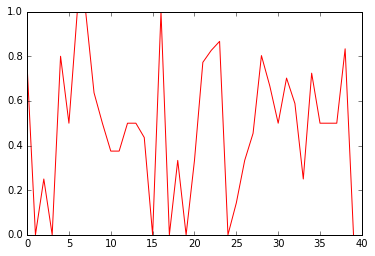

In [36]:
#plt.plot(scores, 'b')
plt.plot(accuracies, 'r')
plt.show()

In [ ]:
run_name = "no_stemming_gru_"+str(NB_LSTM)+"_rmsprop_"+str(LEARNING_RATE)
run_name += "_decay_embedding_"+str(EMBEDDING_DIM)
run_name +="_dropout_"+str(PERC_DROPOUT)+"_early_stop_shuffle"

logpath = generate_unique_logpath("./logs_tensorboard", run_name)
tbcb = TensorBoard(log_dir=logpath)

# TEST 2 
PERC_DROPOUT = 0.2 # to test between 0.2 and 0.5

#Model 
model2= Sequential()
model2.add(Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model2.add(GRU(NB_LSTM))
model2.add(Dropout(PERC_DROPOUT))
model2.add((Dense(NB_CATEGORIES)))
model2.add(Activation('softmax')) # reminder sigmoid if is for binary classification
model2.compile(loss=sparse_categorical_crossentropy, optimizer=optz, metrics=['accuracy'])
print(model2.summary())
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1,  mode='auto')
checkpoint_filepath = os.path.join(logpath,  "model.h1")
checkpoint_cb = ModelCheckpoint(checkpoint_filepath, save_best_only=True)
model2.fit(X_train, y_train,
            validation_data=(X_test, y_test), 
            epochs=EPOCHS,
            shuffle=True,
            batch_size=64,
            verbose=1,
            callbacks=[tbcb])
